In [1]:
from typing import Dict, Tuple

import pandas as pd
import numpy as np
import importlib
from sklearn.model_selection import train_test_split, StratifiedKFold

# visualization tools:
import matplotlib.pyplot as plt
import seaborn as sns

# models:
from xgboost import XGBClassifier

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator
from imblearn.ensemble import BalancedRandomForestClassifier

# evaluation functions:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix



pd.set_option('display.max_columns', 100)


In [2]:
# notebook goal: Setup a basic machine learning framework that cleans data, standardizes features,
#  evaluates feature impt, shap values, and a myriad of ML algorithms
# TODO: add the day-of-week as a feature
# TODO: Add in target date versus historic reference dates
# TODO: Add in volume-based feature functionality
# TODO: Evaluate standardizing features per stock or one model per stock - may not be enough data realistically
# TODO: Check bol-range-pct calculation - only giving zero value
# TODO: Add profit point forecast

In [110]:
# functions:

def clean_stock_data(dataframe: pd.DataFrame) -> pd.DataFrame :

    '''removes nulls and in the future will be built out to do any additonal cleaning on the dataframe that is necessary
    Args:
        dataframe: pandas dataframe containing all of the potential features
        parameters: 
            calculation_field: field on which all of the features are built

    Returns:
        dataframe: dataset that is ready to load into a machine learning framework
    '''

    #TODO: In pipeline write this output to the catalogue
    # remove records the preceed the target period to have complete information:
    dataframe = dataframe.dropna() 
    #dataframe = dataframe.reset_index(drop = True) # we won't reset the index for now for traceability back to the date, ticker combination later after training

    # set the date as an index to us post-forecasting: This is a bad idea, come back to the concept
    #dataframe.set_index(keys = 'date', verify_integrity = False, inplace = True) # verify integrity Fale to allow duplicates**
    
    # remove fields that will not be used as predictive features (can be hardcoded since dataframe structure will be the same):
    dataframe = dataframe.drop(columns = [ 'date', 'high', 'low', 'open', 'volume', 'adj_close'])
    

    return dataframe


def identify_fields_to_standardize(dataframe: pd.DataFrame, parameters: Dict) -> np.array :

    '''creates a list of the continuous fields to standardize by dimension within the predictive model; NOTE: this is used within the standardizer
    
    Args:
        dataframe: dataframe that contains all of the fields of interest to be used in the calculations
        parameters:
            continuous_feature_cutoff: ratio of unique values to record count to be used to codify continuous features -> removes records from the standardization process which don't have enough data to standardize (e.g., boolean)

    Returns: list of continuous fields to use in the standardization process based on user's specifications of "uniqueness" threshold    

    '''

    numeric_fields = dataframe.select_dtypes(include = 'number').columns
    records = len(dataframe)

    record_summary = pd.DataFrame(dataframe[numeric_fields].nunique(), columns = ['unique_values'])
    record_summary['rows_in_df'] = records
    record_summary['value_to_record_ratio'] = record_summary['unique_values']/ record_summary['rows_in_df']

    # filter for a threshold specified by the user:
    record_summary = record_summary[record_summary['value_to_record_ratio'] > parameters['continuous_feature_cutoff']]

    # remove percentage features # TODO: later add in functionality to remove percentage based features

    return record_summary.index


# Justification for approach on scaling - the argument can be made that since our approach will generalize movemements across multiple securities that we need to standardize each security to its own price range.  Therefore, any features with price-relative values will be scaled per the security's price values to avoid odd splits in tree-based algos
# the concern with standardization is generally focused on not letting any one feature have considerably more weight in a model than another; however in this case, 


def standardize_continuous_features(dataframe: pd.DataFrame, parameters: Dict) -> pd.DataFrame:

    '''function that identifies the continuious features in the dataframe and standardizes each feature by equity to enable scaling relative to each equity
    
    Args:
        Dataframe: Pandas dataframe to be used in machine learning
        Parameters:
            stock_field: field indicating the stock for the window function to scan
            calculation_field: field for which the target is being calculated (used for drop in main row merge)
    
    Returns:
        Dataframe: containing the standardized data fields
    
    '''

    continuous_fields = list(identify_fields_to_standardize(dataframe = dataframe, parameters = parameters))

    # add in the ticker for grouping next:
    continuous_fields.append(parameters['stock_field'])

    # downselect to the fields that will be used to standardize:
    continuous_dataframe = dataframe[continuous_fields]

    # calculate z-scores: --> Standardizes within each feature to scale accordingly
    z_scores = (continuous_dataframe - continuous_dataframe.groupby(by = parameters['stock_field']).transform('mean')) / continuous_dataframe.groupby(by = parameters['stock_field']).transform('std')

    # drop the null ticker (not needed post groupby): 
    z_scores.drop(columns = [ parameters['stock_field'], parameters['calculation_field'] ], inplace = True)

    # rename the fields to indicate standardization:
    z_scores.columns = z_scores.columns + '_standardized'

    # drop original continuous fields # TODO: coming back after calculation checks:
    if parameters['drop_original_fields'] == True:
        continuous_fields.remove(parameters['stock_field'])
        dataframe.drop(columns = continuous_fields, inplace = True)

    # append the fields back into the core dataframe:
    z_scores = pd.concat([dataframe, z_scores], axis = 1)

    # remove the standardized target field:
    z_scores.drop(columns = z_scores.columns[z_scores.columns.str.contains('target')][1], inplace = True)

    # remove unnecessary items:
    del continuous_fields, continuous_dataframe

    return z_scores



def one_hot_encode_tickers(dataframe: pd.DataFrame, parameters: Dict) -> pd.DataFrame:

    '''Returns one-hot encoded features to the predictive dataset NOTE: May not work, but this retains some of the information in the original dataframe while also potentially giving the global model a nudge
       Note: we choose not to drop first for now, even though it's a trap; Can be used post processing or as model features
    Args:
        dataframe: core dataset that has been augmented with additional features
        parameters:
            stock_field: text field containing the 3 letter ticker of the dataset
    Returns:   
        dataframe with augmented columns
    
    '''

    dataframe = pd.get_dummies(data = dataframe, prefix = "ind", columns = [parameters['stock_field']], drop_first = False)

    return dataframe


def profile_target_variable(dataframe: pd.DataFrame, parameters: dict):


    '''Function that looks at the target variable and creates an output for the user to review and decide whether rebalancing will help classification task
    Args:
        dataframe: Main resulting dataframe from all data conversion steps
        parameters:
            
    
    '''
    # isolate the target variable:
    target_field = list(dataframe.columns[dataframe.columns.str.contains('target')])

    # create simple value count outputs:
    target_summary_table = pd.DataFrame(dataframe[target_field].value_counts()).reset_index()
    target_summary_table.rename(columns = {0 : 'counts'}, inplace = True)
    target_summary_table['proportion'] = target_summary_table['counts'] / target_summary_table['counts'].sum()

    # create bargraph and save it:
    ''' TODO : resolve ability to output a matplotlib plot in kedro catalog
    sns.countplot(x=target_field, data=dataframe)
    plt.title("Class Distribution")
    plt.show() '''
    target_field =', '.join(dataframe.columns[dataframe.columns.str.contains('target')].str.replace(r'\[|\]', ''))
    positive_proportion = target_summary_table[target_summary_table[target_field].astype(int) == 1]['proportion'].to_list()
   

    print('Classification target: ' + str(target_field) + " contains a class balance of: " + str(positive_proportion) + " in the positive case")
           

    return target_summary_table # TODO: Write this to the catalogue as a reporting output for the users



def create_training_test_splits(dataframe: pd.DataFrame, parameters: Dict) :

    '''Function that splits out training and test sets for machine learning; for the purposes of this model the way we piose the problem allows for random train test split
    Args:
        dataframe: pandas dataframe containing only the target field and the features to be used by the classifier
        parameters:
            test_ratio: proportion of samples in the dataframe to be used as a test set once the models are tuned and evaluated
    
    Returns:
        X_train: training set for use in ML process
        X_test: test set to be held out until all cross-validation is completed
        y_train: training set for target variables
        y_test: test target to be held out until all cross-validation is completed

    '''

    # define Y and x:
    target_feature = list(dataframe.columns[dataframe.columns.str.contains('target')])

    y = dataframe[target_feature]
    X = dataframe.drop(columns = target_feature)

    # create the training and test splits:
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=parameters['test_size'], random_state=parameters['seed'], stratify = y)

    #y_train = y_train.values.ravel()
    #y_test = y_test.values.ravel()

    return X_train, X_test, y_train, y_test


def custom_recall_score(confusion_matrix: np.array) -> np.int64 :

    recall_value = confusion_matrix[1,1] / (confusion_matrix[1,1] + confusion_matrix[1,0])

    return recall_value


def custom_precision_score(confusion_matrix: np.array) -> np.int64 : 

    precision_value = confusion_matrix[1,1] / (confusion_matrix[1,1] + confusion_matrix[0,1])

    return precision_value


def extract_feature_importances(X: np.array, model: BaseEstimator) -> pd.DataFrame:
    
    
    
    # Extract feature importances: 
    feature_importances = model.feature_importances_
    feature_names = [f'feature_{i}' for i in range(X.shape[1])]

    feature_importance_df = pd.DataFrame({
                                          'Feature': feature_names,
                                          'Importance': feature_importances
                                        }
                                        ).sort_values(by='Importance', ascending=False)


    return feature_importance_df


# dynamic import used in the model training pipeline:
def dynamic_import(class_path: str):
    """Dynamically imports a class from its full path."""
    module_name, class_name = class_path.rsplit('.', 1)
    module = importlib.import_module(module_name)
    return getattr(module, class_name)


# new model training function written (1/25):
def train_models(X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.Series, y_test: pd.Series, parameters: dict) -> pd.DataFrame:
    
    '''WRITE DOCUMENTATION'''
    
    # Convert y_train to a 1D array if it's a DataFrame
    #y_train = y_train.iloc[:, 0].values if isinstance(y_train, pd.DataFrame) else y_train.values
    y_train = y_train.values.ravel() if isinstance(y_train, pd.DataFrame) else y_train.ravel()
    # Store feature names from the DataFrame
    feature_names = X_train.columns
    
    # Initialize metrics storage
    model, classifier_details, fold = [], [], []
    train_aucs, test_aucs = [], []
    train_precisions, test_precisions = [], []
    train_recalls, test_recalls = [], []
    train_f_scores, test_f_scores = [], []
    train_accuracies, test_accuracies = [], []
    train_true_positives, test_true_positives = [], []
    train_true_negatives, test_true_negatives = [], []
    train_false_positives, test_false_positives = [], []
    train_false_negatives, test_false_negatives = [], []
    
    # Initialize feature importance storage
    feature_importances_df = pd.DataFrame()

    # Iterate through classifiers specified in the parameters
    for clf_name, clf_info in parameters['classifiers'].items():
        # Dynamically import and instantiate classifier
        clf_class = dynamic_import(clf_info['class_path'])
        clf_params = clf_info['params']
        clf = clf_class(**clf_params)  # Initialize classifier with params

        print(f'Training: {clf_name} classifier')

        # Cross-validation loop
        cv = StratifiedKFold(n_splits=parameters['cross_val_splits'], shuffle=True, random_state=parameters['seed']).split(X_train, y_train)

        for k, (fold_train, fold_test) in enumerate(cv):
            #clf.fit(X_train.iloc[fold_train], y_train[fold_train])
            clf.fit(X_train.iloc[fold_train], y_train[fold_train])  # Keep DataFrame format
            train_pred = clf.predict(X_train.iloc[fold_train])           
            test_pred = clf.predict(X_train.iloc[fold_test])  
            
            # Predictions (at the 50% threshold)
            train_pred = clf.predict(X_train.iloc[fold_train])
            test_pred = clf.predict(X_train.iloc[fold_test])

            
            # AUC 
            if hasattr(clf, "predict_proba"): # Note: error, means predict proba exists, but must be set to true in params
                train_pred_proba = clf.predict_proba(X_train.iloc[fold_train])[:, 1]
                test_pred_proba = clf.predict_proba(X_train.iloc[fold_test])[:, 1] 

                train_auc = get_roc_auc_score(y_pred = train_pred_proba, y_true = y_train[fold_train], return_plot = False)
                test_auc = get_roc_auc_score(y_pred = test_pred_proba, y_true = y_train[fold_test], return_plot = False)

            else:
                train_auc = np.nan
                test_auc = np.nan
            
            
            # Confusion matrices
            train_confusion_matrix = confusion_matrix(y_train[fold_train], train_pred)
            test_confusion_matrix = confusion_matrix(y_train[fold_test], test_pred)

            # Accuracy
            train_accuracy = clf.score(X_train.iloc[fold_train], y_train[fold_train])
            test_accuracy = clf.score(X_train.iloc[fold_test], y_train[fold_test])

            # Precision
            train_precision = precision_score(y_train[fold_train], train_pred)
            test_precision = precision_score(y_train[fold_test], test_pred)

            # Recall
            train_recall = recall_score(y_train[fold_train], train_pred)
            test_recall = recall_score(y_train[fold_test], test_pred)

            # F1 Score
            train_f = f1_score(y_train[fold_train], train_pred)
            test_f = f1_score(y_train[fold_test], test_pred)

            # True/False Positives/Negatives
            train_tp = train_confusion_matrix[1,1]
            test_tp = test_confusion_matrix[1,1]
            train_tn = train_confusion_matrix[0,0]
            test_tn = test_confusion_matrix[0,0]
            train_fp = train_confusion_matrix[0,1]
            test_fp = test_confusion_matrix[0,1]
            train_fn = train_confusion_matrix[1,0]
            test_fn = test_confusion_matrix[1,0]

            # Append metrics
            model.append(clf_name)
            classifier_details.append(clf)
            fold.append(k)
            train_aucs.append(train_auc)
            test_aucs.append(test_auc)
            train_accuracies.append(train_accuracy)
            test_accuracies.append(test_accuracy)
            train_precisions.append(train_precision)
            test_precisions.append(test_precision)
            train_recalls.append(train_recall)
            test_recalls.append(test_recall)
            train_f_scores.append(train_f)
            test_f_scores.append(test_f)
            train_true_positives.append(train_tp)
            test_true_positives.append(test_tp)
            train_true_negatives.append(train_tn)
            test_true_negatives.append(test_tn)
            train_false_positives.append(train_fp)
            test_false_positives.append(test_fp)
            train_false_negatives.append(train_fn)
            test_false_negatives.append(test_fn)

            # Extract feature importances or coefficients
            if hasattr(clf, "coef_"):  # For LogisticRegression and other linear models
                feature_importances = clf.coef_.flatten()
                temp_df = pd.DataFrame({
                    "model": [clf_name]*len(feature_importances),
                    "fold": [k]*len(feature_importances),
                    "feature": feature_names,
                    "importance": feature_importances
                })
                feature_importances_df = pd.concat([feature_importances_df, temp_df], ignore_index=True)
            
            elif hasattr(clf, "feature_importances_"):  # For RandomForest, XGBoost, and other ensemble/non-linear models
                feature_importances = clf.feature_importances_
                temp_df = pd.DataFrame({
                    "model": [clf_name]*len(feature_importances),
                    "fold": [k]*len(feature_importances),
                    "feature": feature_names,
                    "importance": feature_importances
                })
                feature_importances_df = pd.concat([feature_importances_df, temp_df], ignore_index=True)

    # Summary of feature importances
    feature_importances_summary_df = feature_importances_df.groupby(['model', 'feature']).agg(
        importance_value=('importance', 'mean')).reset_index()

    # Detailed results DataFrame
    detailed_results_df = pd.DataFrame({
        "model": model,
        "classifier_details": classifier_details,
        "fold": fold,
        "train_auc" : train_aucs,
        "test_auc" : test_aucs,
        "train_accuracy": train_accuracies,
        "test_accuracy": test_accuracies,
        "train_precision": train_precisions,
        "test_precision": test_precisions,
        "train_recall": train_recalls,
        "test_recall": test_recalls,
        "train_true_positives": train_true_positives,
        "test_true_positives": test_true_positives,
        "train_true_negatives": train_true_negatives,
        "test_true_negatives": test_true_negatives,
        "train_false_positives": train_false_positives,
        "test_false_positives": test_false_positives,
        "train_false_negatives": train_false_negatives,
        "test_false_negatives": test_false_negatives
    })

    # Aggregated results
    results_df = detailed_results_df.groupby('model').agg({
        'train_auc' : 'mean',
        'test_auc' : 'mean',
        'train_accuracy': 'mean',
        'test_accuracy': 'mean',
        'train_precision': 'mean',
        'test_precision': 'mean',
        'train_recall': 'mean',
        'test_recall': 'mean',
        'train_true_positives': 'sum',
        'test_true_positives': 'sum',
        'train_true_negatives': 'sum',
        'test_true_negatives': 'sum',
        'train_false_positives': 'sum',
        'test_false_positives': 'sum',
        'train_false_negatives': 'sum',
        'test_false_negatives': 'sum'
    }).reset_index()

    # Add in overall positve-class rates to the datasets:
    results_df['train_positive_rate'] = (results_df['train_true_positives'] + results_df['train_false_negatives']) / (results_df['train_true_positives'] + results_df['train_false_negatives'] + results_df['train_false_positives'] + results_df['train_true_negatives'])
    results_df['test_positive_rate'] = (results_df['test_true_positives'] + results_df['test_false_negatives']) / (results_df['test_true_positives'] + results_df['test_false_negatives'] + results_df['test_false_positives'] + results_df['test_true_negatives'])

    # share message with complete:
    print('------------------')
    print('Training evaluation completed')
    print('------------------')

    return detailed_results_df, results_df, feature_importances_df, feature_importances_summary_df




def select_champion_model(models: pd.DataFrame, parameters: str):
    """
    Selects the champion model based on the highest or lowest value of a given optimization target.
    
    Args:
    - models: A DataFrame containing model performance metrics.
    - optimization_target: The metric by which to select the champion model (e.g., 'test_precision', 'test_recall', 'test_false_positives').
    
    Returns:
    - champion_model: The row corresponding to the selected champion model.
    """
    
    
    if parameters['optimization_target'] not in models.columns:
        raise ValueError(f"'{parameters['optimization_target'] }' not found in model metrics. Choose from: {list(models.columns)}")
    
    # Determine whether we want the highest or lowest value
    # Assuming metrics like 'precision', 'recall', 'accuracy' need the highest, and 'false positives', 'false negatives', etc. need the lowest
    if 'precision' in parameters['optimization_target']  or 'recall' in parameters['optimization_target']  or 'accuracy' in parameters['optimization_target'] :
        ascending = False  # We want to maximize these metrics
   
    else:
        ascending = True  # For counts (e.g., false positives), we want the minimum value
    
    # Sort the models based on the optimization target
    sorted_models = models.sort_values(by=parameters['optimization_target'] , ascending=ascending)
    
    # Return the top model (first row after sorting)
    champion_model = pd.DataFrame(sorted_models.iloc[0]).reset_index()

    champion_model.columns = ['element', 'value']
    

    return champion_model




In [111]:
#df = catalog.load('combined_modeling_input')
df = pd.read_csv('../data/03_primary/combined_modeling_input.csv')

In [130]:
# setup the parameters for the model: 

parameters = {'continuous_feature_cutoff' : 0.6,
              'stock_field' : 'ticker',
              'calculation_field' : 'close',
              'drop_original_fields' : True,
              'drop_stock_field': True, # keep this fixed 
              'test_size' : 0.20, # proportion of the dataset held out as the test set
              'seed' : 1187,
              'cross_val_splits' : 5,
              'c' : 1.0,
              'kernel' : 'rbf',
              'gamma' : 'scale',
              'optimization_target' : 'test_recall', # other_useful_inputs: train_accuracy, test_accuracy, train_precision, train_recall, test_recall, true_positives, false_positives
              'optimization_target_threshold' : 0.8, # minimum value of the optimization target needed to be selected as a final model
              'optimization_target_training_threshold' : 0.1, # the maximum allowoable difference (absolute) between training and test optimization targets
              # specify the algorithms to be used:
              'classifiers': {
                'Logistic_regression': {
                    'class_path': 'sklearn.linear_model.LogisticRegression',
                    'params': {'penalty': 'l2', 'C': 1.0, 'max_iter': 100000}
                },
                'Random_forest': {
                    'class_path': 'sklearn.ensemble.RandomForestClassifier',
                    'params': {'n_estimators': 200, 'criterion': 'gini', 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'sqrt'}
                },
                'Support_vector_classifier': {
                    'class_path': 'sklearn.svm.SVC',
                    'params': {'C': 1.0, 'kernel': 'rbf', 'gamma': 'scale', 'probability': True}
                },
                'XGBoost': {
                    'class_path': 'xgboost.XGBClassifier',
                    'params': {'use_label_encoder': False, 'eval_metric': 'logloss'}
                },
                'K_nearest_neighbors': {
                    'class_path': 'sklearn.neighbors.KNeighborsClassifier',
                    'params': {'n_neighbors': 5, 'weights': 'uniform'}
                },
                'Gradient_boosting': {
                    'class_path': 'sklearn.ensemble.GradientBoostingClassifier',
                    'params': {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3}
                },
                'Naive_bayes': {
                    'class_path': 'sklearn.naive_bayes.GaussianNB',
                    'params': {}
                },
                'Balanced_random_forest': {
                    'class_path': 'imblearn.ensemble.BalancedRandomForestClassifier',
                    'params': {'n_estimators': 200, 'max_features': 'sqrt', 'sampling_strategy' : 'all', 'bootstrap' : False, 'replacement' : True}
                },
                'AdaBoost': {
                    'class_path': 'sklearn.ensemble.AdaBoostClassifier',
                    'params': {'n_estimators': 50, 'learning_rate': 1.0, 'algorithm' : 'SAMME'}
                },
                'CatBoost': {
                    'class_path': 'catboost.CatBoostClassifier',
                    'params': {'iterations': 100, 'learning_rate': 0.1, 'depth': 6, 'silent': True}
                }
            }

}
          




In [114]:
# remove the null values from the dataset and drop un-needed columns for the classifier:
test = clean_stock_data(dataframe= df)
# test: standardize features:
test = standardize_continuous_features(dataframe = test, parameters = parameters)
# one-hot encode: 
test = one_hot_encode_tickers(dataframe = test, parameters= parameters)
# create training and test sets
X_train, X_test, y_train, y_test = create_training_test_splits(dataframe=test, parameters= parameters)
# train the models:
detailed_output, summary_output, feat_impt, feat_impt_summary = train_models(X_train = X_train, X_test = X_test, y_train = y_train, y_test= y_test, parameters = parameters)


Training: Logistic_regression classifier
Training: Random_forest classifier
Training: Support_vector_classifier classifier
Training: XGBoost classifier
Training: K_nearest_neighbors classifier
Training: Gradient_boosting classifier
Training: Naive_bayes classifier
Training: Balanced_random_forest classifier
Training: AdaBoost classifier
Training: CatBoost classifier
------------------
Training evaluation completed
------------------


In [7]:
##################################### - Function development HERE

In [135]:
# create a new champion model selection function:

def dynamic_champion_selection(modeling_results_summary: pd.DataFrame, parameters: dict) -> pd.DataFrame:

    '''
    Selects a champion model by optimizing for the user's specified inputs to include train/test minimization

    Inputs:
        modeling_results_summary: output of the initial model selection pipeline
        parameters:
            optimization_target: the KPI that is most important to the task at hand (e.g., test recall)
            minimize_test/train: True or False indicating whether we want to instantiate a parameter for train/test accuracy
            minimum_accuracy_threshold: Minimum value of the optimization target for it to be considered in top models
            maximum_train_test_diff: Maximum amount differential between train and test value of the optimization target to be considered
            maximum_number_of_models: Number of models to be selected for downstream champion

    '''

    if parameters['optimization_target'] not in modeling_results_summary.columns:
        raise ValueError(f"'{parameters['optimization_target']} not found in model outputs. Choose from: {list(modeling_results_summary.columns)} ")
    

    # 1. assess the sort value needed to do the selection appropriately:
    if 'precision' in parameters['optimization_target'] or 'recall' in parameters['optimization_target'] or 'accuracy'in parameters['optimization_target'] or 'auc' in parameters['optimization_target']:
        ascending = False # Get the maximum for these types of measurements
    else: # for counts
        ascending = True # Get the minimum for these types of measurements

    # 2. determine the compliment of the optimization parameter provided:
    if 'train' in parameters['optimization_target']:
        compliment = parameters['optimization_target'].replace('train', 'test')
        print(parameters['optimization_target'])
        print(compliment)
    else: # for test case
        compliment = parameters['optimization_target'].replace('test', 'train')
        print(parameters['optimization_target'])
        print(compliment)

    # 3. Add the difference between the training and test columns:
    modeling_results_summary['opt_train_test_difference'] = abs(modeling_results_summary[parameters['optimization_target']] - modeling_results_summary[compliment])

    # 4. Sort the dataframe and instantiate one to return:
    sorted_models = modeling_results_summary.sort_values(by = parameters['optimization_target'], ascending = ascending)

    # 5. remove models not meeting the minimum threshold: 
    sorted_models = sorted_models[sorted_models[parameters['optimization_target']] >= parameters['optimization_target_threshold']].reset_index(drop = True)

    # 6. optimize for the difference between train and test sets:
    sorted_models = sorted_models[sorted_models['opt_train_test_difference'] <=  parameters['optimization_target_training_threshold']]



    return sorted_models
    


        

        

In [136]:
dynamic_champion_selection(modeling_results_summary = summary_output, parameters = parameters)

test_recall
train_recall


,model,train_auc,test_auc,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_true_positives,test_true_positives,train_true_negatives,test_true_negatives,train_false_positives,test_false_positives,train_false_negatives,test_false_negatives,train_positive_rate,test_positive_rate,opt_train_test_difference
0,Support_vector_classifier,0.700606,0.663158,0.640632,0.630477,0.637371,0.631684,0.978740,0.972661,5156,1281,274,55,2934,747,112,36,0.62152,0.62152,0.006079
1,CatBoost,0.984055,0.887409,0.930038,0.806981,0.914695,0.805601,0.978740,0.908866,5156,1197,2727,513,481,289,112,120,0.62152,0.62152,0.069874
2,XGBoost,1.000000,0.917080,1.000000,0.856539,1.000000,0.870069,1.000000,0.905087,5268,1192,3208,623,0,179,0,125,0.62152,0.62152,0.094913
3,Random_forest,0.977618,0.874509,0.911515,0.773942,0.893064,0.772118,0.974375,0.903557,5133,1190,2593,450,615,352,135,127,0.62152,0.62152,0.070817
4,Gradient_boosting,0.955191,0.837491,0.865266,0.752249,0.842620,0.754710,0.963176,0.891413,5074,1174,2260,420,948,382,194,143,0.62152,0.62152,0.071763
5,Logistic_regression,0.666568,0.645954,0.638390,0.635194,0.654976,0.652136,0.883827,0.886096,4656,1167,755,179,2453,623,612,150,0.62152,0.62152,0.002269
7,AdaBoost,0.696973,0.655087,0.671543,0.651727,0.677314,0.667145,0.900917,0.878491,4746,1157,946,224,2262,578,522,160,0.62152,0.62152,0.022426
8,K_nearest_neighbors,0.907137,0.760620,0.839547,0.720149,0.844398,0.750560,0.909454,0.823839,4791,1085,2325,441,883,361,477,232,0.62152,0.62152,0.085615


In [129]:
summary_output

,model,train_auc,test_auc,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_true_positives,test_true_positives,train_true_negatives,test_true_negatives,train_false_positives,test_false_positives,train_false_negatives,test_false_negatives,train_positive_rate,test_positive_rate,opt_train_test_difference
0,AdaBoost,0.696973,0.655087,0.671543,0.651727,0.677314,0.667145,0.900917,0.878491,4746,1157,946,224,2262,578,522,160,0.62152,0.62152,0.022426
1,Balanced_random_forest,1.000000,0.930430,0.998702,0.862678,1.000000,0.897765,0.997912,0.879275,5257,1158,3208,670,0,132,11,159,0.62152,0.62152,0.118637
2,CatBoost,0.984055,0.887409,0.930038,0.806981,0.914695,0.805601,0.978740,0.908866,5156,1197,2727,513,481,289,112,120,0.62152,0.62152,0.069874
3,Gradient_boosting,0.955191,0.837491,0.865266,0.752249,0.842620,0.754710,0.963176,0.891413,5074,1174,2260,420,948,382,194,143,0.62152,0.62152,0.071763
4,K_nearest_neighbors,0.907137,0.760620,0.839547,0.720149,0.844398,0.750560,0.909454,0.823839,4791,1085,2325,441,883,361,477,232,0.62152,0.62152,0.085615
5,Logistic_regression,0.666568,0.645954,0.638390,0.635194,0.654976,0.652136,0.883827,0.886096,4656,1167,755,179,2453,623,612,150,0.62152,0.62152,0.002269
6,Naive_bayes,0.619591,0.614055,0.583648,0.578089,0.710564,0.708645,0.556951,0.545950,2934,719,2013,506,1195,296,2334,598,0.62152,0.62152,0.011001
7,Random_forest,0.977618,0.874509,0.911515,0.773942,0.893064,0.772118,0.974375,0.903557,5133,1190,2593,450,615,352,135,127,0.62152,0.62152,0.070817
8,Support_vector_classifier,0.700606,0.663158,0.640632,0.630477,0.637371,0.631684,0.978740,0.972661,5156,1281,274,55,2934,747,112,36,0.62152,0.62152,0.006079
9,XGBoost,1.000000,0.917080,1.000000,0.856539,1.000000,0.870069,1.000000,0.905087,5268,1192,3208,623,0,179,0,125,0.62152,0.62152,0.094913


In [8]:
##################################### - Testing functions HERE

In [9]:
# pick a champion model (original): 

def select_champion_model(models: pd.DataFrame, parameters: str) -> pd.DataFrame:
    """
    Selects the champion model based on the highest or lowest value of a given optimization target.
    
    Args:
    - models: A DataFrame containing model performance metrics.
    - optimization_target: The metric by which to select the champion model (e.g., 'test_precision', 'test_recall', 'test_false_positives').
    
    Returns:
    - champion_model: The row corresponding to the selected champion model.
    """
    
    
    if parameters['optimization_target'] not in models.columns:
        raise ValueError(f"'{parameters['optimization_target'] }' not found in model metrics. Choose from: {list(models.columns)}")
    
    # Determine whether we want the highest or lowest value
    # Assuming metrics like 'precision', 'recall', 'accuracy' need the highest, and 'false positives', 'false negatives', etc. need the lowest
    if 'precision' in parameters['optimization_target']  or 'recall' in parameters['optimization_target']  or 'accuracy' in parameters['optimization_target'] :
        ascending = False  # We want to maximize these metrics
   
    else:
        ascending = True  # For counts (e.g., false positives), we want the minimum value
    
    # Sort the models based on the optimization target
    sorted_models = models.sort_values(by=parameters['optimization_target'] , ascending=ascending)
    
    # Return the top model (first row after sorting)
    champion_model = pd.DataFrame(sorted_models.iloc[0]).reset_index()

    champion_model.columns = ['element', 'value']
    

    return champion_model

In [116]:
champion_model = select_champion_model(models = detailed_output, parameters= parameters)



In [117]:
champion_model




,element,value
0,model,Support_vector_classifier
1,classifier_details,SVC(probability=True)
2,fold,3
3,train_auc,0.698313
4,test_auc,0.676015
5,train_accuracy,0.633038
6,test_accuracy,0.636792
7,train_precision,0.630751
8,test_precision,0.633252
9,train_recall,0.988615


### Next to-dos:  
1.) Add parameters for all Classifiers to the parameters model  
TODO: Add in ROC/Precision-recall curve
Add SMOTE  
Add Train and test class balances
2.) Add Select "n" best logic to the outputs
3.) Add in feature importances and feature selection before modeling run
3.) Add in Hypterparameter tuning
4.) Run with more positions/equity holdings

In [108]:

# refactor ML function to dynamically import any SKlearn module:





In [109]:
# test out the new function outputs:

detailed_output, summary_output, feat_impt, feat_impt_summary = train_models(X_train = X_train, X_test = X_test, y_train = y_train, y_test= y_test, parameters = parameters)



Training: Logistic_regression classifier
Training: Random_forest classifier
Training: Support_vector_classifier classifier
Training: XGBoost classifier
Training: K_nearest_neighbors classifier
Training: Gradient_boosting classifier
Training: Naive_bayes classifier
Training: Balanced_random_forest classifier
Training: AdaBoost classifier
Training: CatBoost classifier
------------------
Training evaluation completed
------------------


In [93]:
summary_output.head(10)

,model,train_auc,test_auc,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_true_positives,test_true_positives,train_true_negatives,test_true_negatives,train_false_positives,test_false_positives,train_false_negatives,test_false_negatives,train_positive_rate,test_positive_rate
0,AdaBoost,0.696973,0.655087,0.671543,0.651727,0.677314,0.667145,0.900917,0.878491,4746,1157,946,224,2262,578,522,160,0.62152,0.62152
1,Balanced_random_forest,1.000000,0.929390,0.998466,0.860790,1.000000,0.890801,0.997532,0.884586,5255,1165,3208,659,0,143,13,152,0.62152,0.62152
2,CatBoost,0.984055,0.887409,0.930038,0.806981,0.914695,0.805601,0.978740,0.908866,5156,1197,2727,513,481,289,112,120,0.62152,0.62152
3,Gradient_boosting,0.955187,0.836820,0.865384,0.751778,0.842758,0.754892,0.963176,0.889898,5074,1172,2261,421,947,381,194,145,0.62152,0.62152
4,K_nearest_neighbors,0.907137,0.760620,0.839547,0.720149,0.844398,0.750560,0.909454,0.823839,4791,1085,2325,441,883,361,477,232,0.62152,0.62152
5,Logistic_regression,0.666568,0.645954,0.638390,0.635194,0.654976,0.652136,0.883827,0.886096,4656,1167,755,179,2453,623,612,150,0.62152,0.62152
6,Naive_bayes,0.619591,0.614055,0.583648,0.578089,0.710564,0.708645,0.556951,0.545950,2934,719,2013,506,1195,296,2334,598,0.62152,0.62152
7,Random_forest,0.977650,0.876040,0.910217,0.777247,0.893953,0.774567,0.970768,0.905833,5114,1193,2601,454,607,348,154,124,0.62152,0.62152
8,Support_vector_classifier,0.700598,0.663241,0.640632,0.630477,0.637371,0.631684,0.978740,0.972661,5156,1281,274,55,2934,747,112,36,0.62152,0.62152
9,XGBoost,1.000000,0.917080,1.000000,0.856539,1.000000,0.870069,1.000000,0.905087,5268,1192,3208,623,0,179,0,125,0.62152,0.62152


In [ ]:
# Develop the ROC/AUC function

In [106]:
from sklearn.metrics import roc_curve, auc

def get_roc_auc_score(y_pred: np.array, y_true: np.array, return_plot: bool) -> np.array:

    '''Function that returns the auc of the model being run with the functionality to 
    return the graph output which will be stored in Kedro outputs
    
        Args:
    - y_pred: predictions from the machine learning model
    - y_actual: actual values being predicted by the machine learning model
    
    Returns:
    - auc: area under the curve; A higher AUC indicates better classification performance
    
    '''

    # calculate the tpr and fpr for the different threshold values of the classifier outputs: 
    fpr, tpr, thresholds = roc_curve(y_true = y_true, y_score = y_pred)

    # AUC calculation:
    auc_output = auc( x = fpr, y = tpr )

    if return_plot == True:
        fig, ax = plt.subplots()
        ax.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc_output:.2f})')
        ax.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')  # Random guess line
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC Curve' + str(clf))
        ax.legend(loc='lower right')

        return fig, auc_output
    
    else:
        return auc_output





(<Figure size 640x480 with 1 Axes>, 0.6682393503606587)

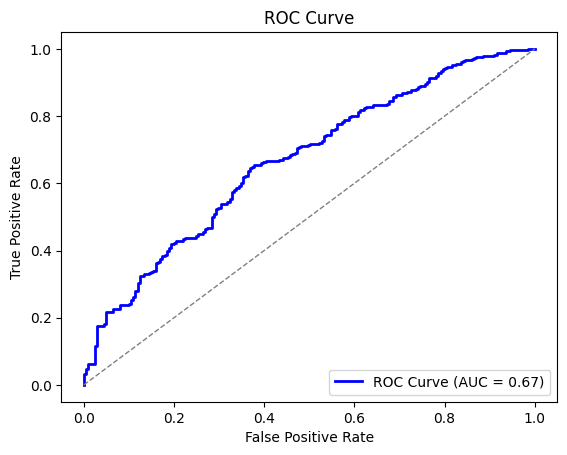

In [99]:
# Initialize the classifier
clf = LogisticRegression(solver='lbfgs', max_iter=1000)
# Train the model
clf.fit(X_train, y_train.values.ravel())

# Predict class labels and probabilities
y_pred = clf.predict(X_test)               # Predictions (0 or 1)
y_proba = clf.predict_proba(X_test)[:, 1]         # Probabilities for class 1

get_roc_auc_score(y_pred= y_proba, y_true = y_test, return_plot = True)



In [ ]:
#############

In [41]:
### Modifying the champion model selector to:
# pick multiple potential champions for stacking
# Pick a minimum threshold for the optimization target
# Also solve for the optimization of the difference between train and test split with a min threshold applied


def select_champion_model(models: pd.DataFrame, parameters: str) -> pd.DataFrame:
    """
    Selects the champion model based on the highest or lowest value of a given optimization target.
    
    Args:
    - models: A DataFrame containing model performance metrics.
    - optimization_target: The metric by which to select the champion model (e.g., 'test_precision', 'test_recall', 'test_false_positives').
    
    Returns:
    - champion_model: The row corresponding to the selected champion model.
    """
    
    
    if parameters['optimization_target'] not in models.columns:
        raise ValueError(f"'{parameters['optimization_target'] }' not found in model metrics. Choose from: {list(models.columns)}")
    
    # Determine whether we want the highest or lowest value
    # Assuming metrics  'precision', 'recall', 'accuracy' need the highest, and 'false positives', 'false negatives', etc. need the lowest
    if 'precision' in parameters['optimization_target']  or 'recall' in parameters['optimization_target']  or 'accuracy' in parameters['optimization_target'] :
        ascending = False  # We want to maximize these metrics
   
    else:
        ascending = True  # For counts (e.g., false positives), we want the minimum value
    

    # Sort the models based on the optimization target
    sorted_models = models.sort_values(by=parameters['optimization_target'] , ascending=ascending)

    # Drop models that do no meet the specified performance threshold:
    sorted_models = sorted_models[sorted_models[parameters['optimization_target']] > parameters['optimization_threshold']].reset_index(drop = True)
    
    # Return the top model (first row after sorting)
    champion_model = pd.DataFrame(sorted_models.iloc[0]).reset_index()

    champion_model.columns = ['element', 'value']
    

    return  champion_model

In [42]:
select_champion_model(models = summary_output, parameters = parameters)

,element,value
0,model,Support_vector_classifier
1,train_accuracy,0.640632
2,test_accuracy,0.630477
3,train_precision,0.637371
4,test_precision,0.631684
5,train_recall,0.97874
6,test_recall,0.972661
7,train_true_positives,5156
8,test_true_positives,1281
9,train_true_negatives,274


In [40]:
summary_output

,model,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_true_positives,test_true_positives,train_true_negatives,test_true_negatives,train_false_positives,test_false_positives,train_false_negatives,test_false_negatives,train_positive_rate,test_positive_rate
0,AdaBoost,0.671543,0.651727,0.677314,0.667145,0.900917,0.878491,4746,1157,946,224,2262,578,522,160,0.62152,0.62152
1,Balanced_random_forest,0.998938,0.860319,1.000000,0.892644,0.998291,0.881545,5259,1161,3208,662,0,140,9,156,0.62152,0.62152
2,CatBoost,0.930038,0.806981,0.914695,0.805601,0.978740,0.908866,5156,1197,2727,513,481,289,112,120,0.62152,0.62152
3,Gradient_boosting,0.865266,0.752721,0.842620,0.755570,0.963176,0.890656,5074,1173,2260,422,948,380,194,144,0.62152,0.62152
4,K_nearest_neighbors,0.839547,0.720149,0.844398,0.750560,0.909454,0.823839,4791,1085,2325,441,883,361,477,232,0.62152,0.62152
5,Logistic_regression,0.638390,0.635194,0.654976,0.652136,0.883827,0.886096,4656,1167,755,179,2453,623,612,150,0.62152,0.62152
6,Naive_bayes,0.583648,0.578089,0.710564,0.708645,0.556951,0.545950,2934,719,2013,506,1195,296,2334,598,0.62152,0.62152
7,Random_forest,0.911161,0.773003,0.894287,0.771242,0.972097,0.902809,5121,1189,2602,449,606,353,147,128,0.62152,0.62152
8,Support_vector_classifier,0.640632,0.630477,0.637371,0.631684,0.978740,0.972661,5156,1281,274,55,2934,747,112,36,0.62152,0.62152
9,XGBoost,1.000000,0.856539,1.000000,0.870069,1.000000,0.905087,5268,1192,3208,623,0,179,0,125,0.62152,0.62152
